```{index} single: Pyomo; block
```
```{index} single: Pyomo; kernel library
```
```{index} single: conic programming; second order cones
```
```{index} single: solver; mosek
```
```{index} single: application; building insulation
```
# Optimal Design of Multilayered Building Insulation

Thermal insulation is installed in buildings to reduce annual energy costs. However, the installation costs money, so the decision of how much insulation to install is a trade-off between the annualized capital costs of insulation and the annual operating costs for heating and air conditioning. This notebook shows the formulation and solution of an optimization problem using conic programming.

In [1]:
  # install Pyomo and solvers
import sys

if "google.colab" in sys.modules:
    !pip install -q idaes-pse >/dev/null 2>/dev/null
    !idaes -q get-extensions
    import idaes
    CONIC_SOLVER = "/root/.idaes/bin/ipopt"

else:
    CONIC_SOLVER = "mosek_direct"

## A Model for Multi-Layered Insulation

Consider a wall or surface separating conditioned interior space in a building at temperature $T_i$ from the external environment at temperature $T_o$. Heat conduction through the wall is given by

$$\dot{Q} = UA (T_i - T_o),$$

where $U$ is the overall heat transfer coefficient and and $A$ is the heat transfer area. For a wall constructed from $N$ layers of different insulating materials, the inverse of the overall heat transfer coefficient $U$ is given by a sum of serial thermal "resistances"

$$\frac{1}{U} = R_0 + \sum_{n=1}^N R_n,$$

where $R_0$ is the thermal resistance of the structural elements. The thermal resistance of the $n$-th insulating layer is equal to $R_n = \frac{x_n}{k_n}$ for a material with thickness $x_n$ and a thermal conductivity $k_n$, so we can rewrite

$$\frac{1}{U} = R_0 + \sum_{n=1}^N \frac{x_n}{k_n}.$$

The economic objective is to minimize the cost $C$, obtained as the combined annual energy operating expenses and capital cost of insulation. 

We assume the annual energy costs are proportional to overall heat transfer coefficient $U$ and let $\alpha \geq 0$ be the coefficient for the proportional relationship of the overall heat transfer coefficient $U$ to the annual energy costs. Furthermore, we assume the cost of installing a unit area of insulation in the $n$-th layer is given by the affine expression $a_n + b_n x_n$. The combined annualized costs are then

$$C = \alpha U + \beta\sum_{n=1}^N (a_n y_n + b_n x_n),$$

where $\beta$ is a discount factor for the equivalent annualized cost of insulation, and $y_n$ is a binary variable that indicates whether or not layer $n$ is included in the installation. The feasible values for $x_n$ are subject to constraints

$$\begin{align}
x_n & \leq Ty_n \\
\sum_{n=1}^N x_n & \leq T
\end{align}$$

where $T$ is an upper bound on insulation thickness.


## Analytic solution for $N=1$

In the case of a single layer, i.e., $N=1$, we have a one-dimensional cost optimization problem of which we can obtain a close-form analytical solution directly. Indeed, the expression for the cost $C(x)$ as a function of the thickness $x$ reads

$$\begin{align}
C(x) = \frac{\alpha k}{k R_0 + x} + \beta(a + bx).
\end{align}$$

For fixed parameters $k$, $R_0$, $\beta$, $b$, we can calculate the optimum thickness $x^*$ as

$$x^{*} = - k R_0 + \sqrt{\frac{\alpha k}{\beta b}}.$$

A plot illustrates the trade-off between energy operating costs and capital insulation costs and the corresponding optimal solution $x^*$.


In [2]:
# application parameters
alpha = 30        # $ K / W annualized cost per sq meter per W/sq m/K
beta = 0.05       # equivalent annual cost factor
R0 = 2.0          # Watts/K/m**2
T = 0.30          # maximum insulation thickness

# material properties
k = 0.030         # thermal conductivity as installed
a = 5.0           # installation cost per square meter
b = 150.0         # installed material cost per cubic meter

The optimal cost is equal to 4.99615 per sq. meter
The optimal thickness is 0.28641 meters



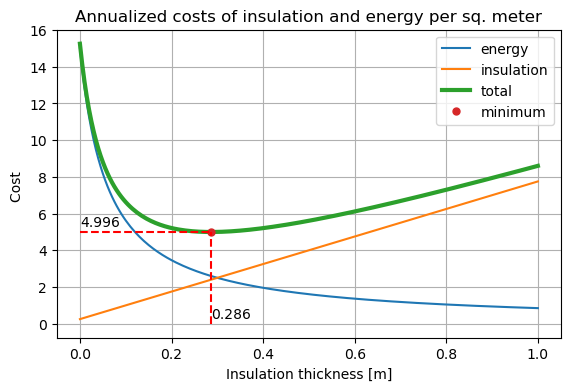

In [3]:
import matplotlib.pyplot as plt
import numpy as np

f = lambda x: alpha/(R0 + x/k)
g = lambda x: beta*(a + b*x)

# solution
xopt =  -k*R0 + np.sqrt(alpha*k/beta/b)

print(f"The optimal cost is equal to {f(xopt) + g(xopt):0.5f} per sq. meter")
print(f"The optimal thickness is {xopt:0.5f} meters\n")

# plotting
x = np.linspace(0, 1, 201)

fig, ax = plt.subplots(1, 1, figsize=(6.5, 4))

ax.plot(x, f(x), label="energy")
ax.plot(x, g(x), label="insulation")
ax.plot(x, f(x) + g(x), label="total", lw=3)
ax.plot(xopt, f(xopt) + g(xopt), '.', ms=10, label="minimum")
ax.legend()

ax.plot([0, xopt], [f(xopt) + g(xopt)]*2, 'r--')
ax.plot([xopt]*2, [0, f(xopt) + g(xopt)], 'r--')
ax.text(0, f(xopt) + g(xopt) + 0.3, f"{f(xopt) + g(xopt):0.3f}")
ax.text(xopt, 0.3, f"{xopt:0.3f}")

ax.set_xlabel("Insulation thickness [m]")
ax.set_ylabel("Cost ")
ax.set_title("Annualized costs of insulation and energy per sq. meter")

ax.grid(True)

## Pyomo Model for $N=1$

In the [Pyomo Kernel Library](https://pyomo.readthedocs.io/en/stable/library_reference/kernel/index.html), a [conic rotated constraint](https://pyomo.readthedocs.io/en/stable/library_reference/kernel/conic.html#pyomo.core.kernel.conic.rotated_quadratic) is of the form   

$$\sum_{n=0}^{N-1} z_n^2 \leq 2 r_1 r_2$$ 

where $r_1$, $r_2$, and $z_0, z_1, \ldots, z_{N-1}$ are variables. For a single layer Pyomo model we identify $R \sim r_1$, $U\sim r_2$, and $z_0^2 \sim 2$ which leads to the model

$$
\begin{align}
\min \quad & \alpha U + \beta(a + bx)\\
\text{s.t.} \quad 
& R = R_0 + \frac{x}{k} \\
& z^2 \leq 2 R U & \text{(conic constraint)}\\
& z = \sqrt{2} \\
& x \leq T\\
& x, R, U \geq 0.
\end{align}
$$

This model can be translated directly into into a Pyomo conic program using the Pyomo Kernel Library.

In [4]:
import pyomo.kernel as pmo
import pyomo.environ as pyo

m = pmo.block()

# decision variables
m.R = pmo.variable(lb=0)
m.U = pmo.variable(lb=0)
m.x = pmo.variable(lb=0, ub=T)

# objective
m.cost = pmo.objective(alpha*m.U + beta*(a + b*m.x))

# insulation model
m.r = pmo.constraint(m.R == R0 + m.x/k)

# conic constraint
m.q = pmo.conic.rotated_quadratic.as_domain(m.R, m.U, [np.sqrt(2)])

# solve
pmo.SolverFactory(CONIC_SOLVER).solve(m)

print(f"The optimal cost is equal to {m.cost():0.5f} per sq. meter")
print(f"The optimal thickness is xopt = {m.x():0.5f} meters")

The optimal cost is equal to 4.99615 per sq. meter
The optimal thickness is xopt = 0.28640 meters


## Multi-Layer Solutions as a Mixed Integer Quadratic Constraint Program (MIQCP)

For multiple layers, we cannot easily find an analytical optimal layer composition and we shall resort to conic optimization. Let $y_n$ be the binary variable that indicates whether layer $n$ is included in the insulation package or not, and $x_n$ be the continuous variable describing the thickness of layer $n$, which is zero if layer $n$ is not included. 

In the general case with $N$ layers, the objective function is given by 

$$
\frac{\alpha}{R} +  \beta \sum_{n=1}^N (a_n y_n + b_n x_n),
$$

where the first term is nonlinear in the variables $x_1,\dots,x_N$ since since the denominator of the first term is equal tosince at the denominator of the first term is equal to

$$
R = R_0 + \sum_{n=1}^N \frac{x_n}{k_n}.
$$

To overcome this issue, we can include $U$ as a decision variable and include a constraint

$$
\frac{1}{R} \leq U.
$$

Since we minimize the objective and $U$ has no other constraint, the problem will guarantee that $U$ is equal to $1/R$. The extra constraint $RU \leq 1$ can be reformulated using an extra decision variable $z$ as:

$$
1 \leq RU \quad \Longleftrightarrow \quad \left\{ \begin{array}{l} z^2 \leq 2RU \\
z = 2 
\end{array}
\right.
\quad \Longleftrightarrow
\quad \left\{ \begin{array}{l} \left\|  \begin{array}{c}
\sqrt{2} z \\
R - U
\end{array}\right\|_2 \leq R + U \\
z = 2
\end{array}
\right.
$$

from which we see that the entire problem can be reformulated as a conic optimization problem. 

The middle formulation above can, in fact, be implemented in Pyomo as a [conic rotated constraint](https://pyomo.readthedocs.io/en/stable/library_reference/kernel/conic.html#pyomo.core.kernel.conic.rotated_quadratic) of the form:

$$
    \sum_{n=0}^{n-1} z_n^2 \leq 2 r_1 r_2.
$$
In our case, we pick $n=1$, $z_0 = z$, $r_1=R$, and $r_2=U$.

Adopting this formulation, the full multi-layer optimization problem then reads:

$$
\begin{align}
\min \quad & \alpha U + \beta \sum_{n=1}^N (a_ny_n + b_nx_n)\\
\text{s.t.} \quad 
& R = R_0 + \sum_{n=1}^N\frac{x_n}{k_n} \\
& x_n \leq T y_n & n=1,\dots,N \\
& \sum_{n=1}^N x_n \leq T \\
& z^2  \leq 2 R U \\
& z  = \sqrt{2} \\
& R, U  > 0\\
& x_n  \geq 0 & n=1,\dots,N \\
& y_n  \in \{0,1\} & n=1,\dots,N
\end{align}
$$

In [5]:
import pyomo.kernel as pmo

def insulate(df, alpha, beta, R0, T):

    m = pmo.block()

    # index set
    m.N = df.index

    a = df["a"]
    b = df["b"]
    k = df["k"]

    # decision variables
    m.R = pmo.variable(lb=0)
    m.U = pmo.variable(lb=0)
    m.x = pmo.variable_dict({n: pmo.variable(lb=0) for n in m.N})
    m.y = pmo.variable_dict({n: pmo.variable(domain=pmo.Binary) for n in m.N})

    # objective
    m.cost = pmo.objective(alpha*m.U + beta*sum(a[n]*m.y[n] + b[n]*m.x[n] for n in m.N))

    # insulation model
    m.insulation = pmo.constraint(m.R == R0 + sum(m.x[n]/k[n] for n in m.N))

    # total thickness limit
    m.thickness = pmo.constraint(sum(m.x[n] for n in m.N) <= T)

    # layer model   
    m.layers = pmo.constraint_dict({n: pmo.constraint(m.x[n] <= T * m.y[n]) for n in m.N})

    # conic constraint
    m.q = pmo.conic.rotated_quadratic.as_domain(m.R, m.U, [np.sqrt(2)])

    # solve
    pmo.SolverFactory(CONIC_SOLVER).solve(m)
    
    for n in m.N:
        df.loc[n, "x opt"] = m.x[n]() 
    print(f"The optimal cost is equal to {m.cost():0.5f} per sq. meter")
    display(df.round(5))
    
    return m


### Case 1. Single Layer Solution

In [6]:
import pandas as pd

# application parameters
alpha = 30        # $ K / W annualized cost per sq meter per W/sq m/K
beta = 0.05       # equivalent annual cost factor
R0 = 2.0          # Watts/K/m**2
T = 0.30          # maximum insulation thickness

df = pd.DataFrame({
    "Mineral Wool": {"k": 0.030, "a": 5.0, "b": 150.0},
    "Rigid Foam (high R)": {"k": 0.015, "a": 8.0, "b": 180.0},
    "Rigid Foam (low R)": {"k": 0.3, "a": 8.0, "b": 120.0}
}).T

m = insulate(df, alpha, beta, R0, T)

The optimal cost is equal to 4.15492 per sq. meter


,k,a,b,x opt
Mineral Wool,0.030,5.0,150.0,0.00000
Rigid Foam (high R),0.015,8.0,180.0,0.19361
Rigid Foam (low R),0.300,8.0,120.0,0.00000


### Case 2. Multiple Layer Solution

In [7]:
# application parameters
alpha = 30        # $ K / W annualized cost per sq meter per W/sq m/K
beta = 0.05       # equivalent annual cost factor
R0 = 2.0          # Watts/K/m**2
T = 0.15          # maximum insulation thickness

df = pd.DataFrame({
    "Foam": {"k": 0.015, "a": 0.0, "b": 110.0},
    "Wool": {"k": 0.010, "a": 0.0, "b": 200.0},
}).T

m = insulate(df, alpha, beta, R0, T)

The optimal cost is equal to 3.22992 per sq. meter


,k,a,b,x opt
Foam,0.015,0.0,110.0,0.06276
Wool,0.010,0.0,200.0,0.08724


The plot below gives a graphical representation of the 2-layer problem we just solved. The green line represents the thickness constraint $x_0+x_1 \leq T$, the curves are the isolines of the objective function, and the optimal solution $x^*=(x_0^*,x_1^*)$ is highlighted in red.

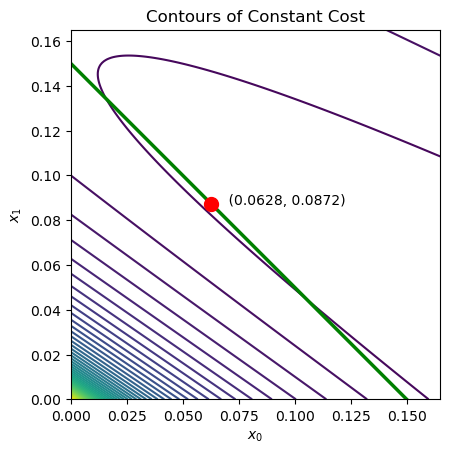

In [8]:
import numpy as np
import matplotlib.pyplot as plt

k = list(df["k"])
a = list(df["a"])
b = list(df["b"])

f = lambda x0, x1: alpha/(R0 + x0/k[0] + x1/k[1]) + beta*(a[0] + b[0]*x0 + a[1] + b[1]*x1)

x0 = np.linspace(0, 1.1*T, 201)
x1 = np.linspace(0, 1.1*T, 201)

X0, X1 = np.meshgrid(x0, x1)

fig, ax = plt.subplots(1, 1)
ax.contour(x0, x1, f(X0, X1), 50)
ax.set_xlim(min(x0), max(x0))
ax.set_ylim(min(x1), max(x1))
ax.plot([0, T], [T, 0], 'g', lw=2.5)

ax.set_aspect(1)

x = list(m.x[n]() for n in m.N)
ax.plot(x[0], x[1], 'r.', ms=20)
ax.text(x[0], x[1], f"    ({x[0]:0.4f}, {x[1]:0.4f})")

ax.set_xlabel(r"$x_0$")
ax.set_ylabel(r"$x_1$")
ax.set_title("Contours of Constant Cost")
plt.show()

## Bibliographic Notes

To the best of my knowledge, this problem is not well-known example in the mathematical optimization literature. There are a number of application papers with differing levels of detail. 

> Hasan, A. (1999). Optimizing insulation thickness for buildings using life cycle cost. Applied energy, 63(2), 115-124. https://www.sciencedirect.com/science/article/pii/S0306261999000239

> Kaynakli, O. (2012). A review of the economical and optimum thermal insulation thickness for building applications. Renewable and Sustainable Energy Reviews, 16(1), 415-425. https://www.sciencedirect.com/science/article/pii/S1364032111004163

> Nyers, J., Kajtar, L., Tomić, S., & Nyers, A. (2015). Investment-savings method for energy-economic optimization of external wall thermal insulation thickness. Energy and Buildings, 86, 268-274.  https://www.sciencedirect.com/science/article/pii/S0378778814008688

More recently some modeling papers have appeared

> Gori, P., Guattari, C., Evangelisti, L., & Asdrubali, F. (2016). Design criteria for improving insulation effectiveness of multilayer walls. International Journal of Heat and Mass Transfer, 103, 349-359. https://www.sciencedirect.com/science/article/abs/pii/S0017931016303647

> Huang, H., Zhou, Y., Huang, R., Wu, H., Sun, Y., Huang, G., & Xu, T. (2020). Optimum insulation thicknesses and energy conservation of building thermal insulation materials in Chinese zone of humid subtropical climate. Sustainable Cities and Society, 52, 101840. https://www.sciencedirect.com/science/article/pii/S221067071931457X

> Söylemez, M. S., & Ünsal, M. (1999). Optimum insulation thickness for refrigeration applications. Energy Conversion and Management, 40(1), 13-21. https://www.sciencedirect.com/science/article/pii/S0196890498001253

> Açıkkalp, E., & Kandemir, S. Y. (2019). A method for determining optimum insulation thickness: Combined economic and environmental method. Thermal Science and Engineering Progress, 11, 249-253. https://www.sciencedirect.com/science/article/pii/S2451904918305377

> Ylmén, P., Mjörnell, K., Berlin, J., & Arfvidsson, J. (2021). Approach to manage parameter and choice uncertainty in life cycle optimisation of building design: Case study of optimal insulation thickness. Building and Environment, 191, 107544. https://www.sciencedirect.com/science/article/pii/S0360132320309112